In [80]:
# ## install finrl library
# !pip install wrds
# !pip install quantstats
# !pip install torch_geometric
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL-Fork.git

In [81]:
import warnings
warnings.filterwarnings("ignore")

In [82]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

In [83]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [84]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [85]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (107677, 8)


In [86]:
# INDICATORS = ['macd',
#             'rsi_30',
#             'cci_30',
#             'dx_30']

In [87]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

# # here you can see the engineered features are added to each stock day
# print(processed)


In [88]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)
portfolio_norm_df

,date,open,high,low,close,volume,tic,day
0,2009-04-01,0.018773,0.019501,0.018834,0.016610,0.313329,AAPL,0.5
1,2009-04-01,0.165873,0.164931,0.162829,0.121385,0.216841,AMGN,0.5
2,2009-04-01,0.067544,0.073365,0.066315,0.059964,0.306650,AXP,0.5
3,2009-04-01,0.077397,0.079819,0.077716,0.062400,0.089997,BA,0.5
4,2009-04-01,0.092561,0.098663,0.092690,0.065151,0.243804,CAT,0.5
...,...,...,...,...,...,...,...,...
107672,2023-12-29,0.947712,0.946497,0.952357,0.955325,0.059607,UNH,1.0
107673,2023-12-29,0.990045,0.993200,1.000000,0.992263,0.012072,V,1.0
107674,2023-12-29,0.602806,0.606879,0.608313,0.722690,0.026281,VZ,1.0
107675,2023-12-29,0.272493,0.273690,0.267421,0.363286,0.129006,WBA,1.0


In [89]:
portfolio_norm_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
AAPL,3713,3713,3713,3713,3713,3713,3713
AMGN,3713,3713,3713,3713,3713,3713,3713
AXP,3713,3713,3713,3713,3713,3713,3713
BA,3713,3713,3713,3713,3713,3713,3713
CAT,3713,3713,3713,3713,3713,3713,3713
CRM,3713,3713,3713,3713,3713,3713,3713
CSCO,3713,3713,3713,3713,3713,3713,3713
CVX,3713,3713,3713,3713,3713,3713,3713
DIS,3713,3713,3713,3713,3713,3713,3713


In [90]:
stock_dimension = len(portfolio_norm_df.tic.unique())
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 29


In [91]:
df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

# TODO use the start and end date here

In [92]:
  # TODO here they use the covariance matrix for the state, look at the tutorial for:
 # FinRL_PortfolioAllocation_NeurIPS_2020

environment = PortfolioOptimizationEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

In [93]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

In [94]:

# Once optimal policy is learned it shouldnt be stochastic, giventhe state

# Uncomment to train a new model
# model = DRLAgent.train_model(model, episodes=50)

# torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

  0%|          | 0/50 [01:03<?, ?it/s]


KeyboardInterrupt: 

In [95]:
# Test it

environment_2021 = PortfolioOptimizationEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptimizationEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

In [96]:
EIIE_results = {
    "date": environment._date_memory,
    "training": environment._asset_memory["final"],
    "2021": {},
    "2022": {},
    "2023": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]
EIIE_results["2021"]["date"] = environment_2021._date_memory


# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]
EIIE_results["2022"]["date"] = environment_2022._date_memory

# 2023
DRLAgent.DRL_validation(model, environment_2023, policy=policy)
EIIE_results["2023"]["value"] = environment_2023._asset_memory["final"]
EIIE_results["2023"]["date"] = environment_2023._date_memory

Initial portfolio value:1000000
Final portfolio value: 1160039.5
Final accumulative portfolio value: 1.1600395
Maximum DrawDown: -0.06613053125321344
Sharpe ratio: 1.457363558973067
Total commission cost: 2044.2718397032004
{'initial': [1000000, 1000000.0, 999089.3963991201, 1000371.9610686015, 1000983.8018603561, 1002435.2230110796, 1003377.5993399776, 1007438.0694568958, 1004212.8234914866, 1003012.9486881063, 1003803.036947009, 1004877.2664058083, 1017510.4472830456, 1001099.2990425851, 985957.6070291338, 1004421.4206734806, 999154.6222460207, 995846.4961085904, 984742.288080785, 1004074.9071270529, 1013919.3758827506, 1015590.5990062199, 1030345.6722342711, 1035182.551873995, 1043302.415225753, 1051373.2768191097, 1048322.7250978973, 1052771.1326169455, 1045209.4704235335, 1037870.5046552267, 1043263.3064127712, 1034522.4818886647, 1033707.669526405, 1039842.0997853092, 1056508.309312939, 1060209.821840896, 1055312.630472421, 1053614.9677558257, 1058848.6250759054, 1072209.21663579

In [97]:
UBAH_results = {
    "train": {},
    "2021": {},
    "2022": {},
    "2023": {},
}

PORTFOLIO_SIZE = len(DOW_30_TICKER)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]
UBAH_results["train"]["date"] = environment._date_memory

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]
UBAH_results["2021"]["date"] = environment_2021._date_memory

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]
UBAH_results["2022"]["date"] = environment_2022._date_memory

# 2023
terminated = False
environment_2023.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2023.step(action)
UBAH_results["2023"]["value"] = environment_2023._asset_memory["final"]
UBAH_results["2023"]["date"] = environment_2023._date_memory

print(UBAH_results)

Initial portfolio value:1000000
Final portfolio value: 6930860.0
Final accumulative portfolio value: 6.93086
Maximum DrawDown: -0.33119673751775747
Sharpe ratio: 1.052415136396501
Total commission cost: 75581.43403853441
Initial portfolio value:1000000
Final portfolio value: 1160040.125
Final accumulative portfolio value: 1.160040125
Maximum DrawDown: -0.06613112406841604
Sharpe ratio: 1.457350691920846
Total commission cost: 2044.3086096462794
Initial portfolio value:1000000
Final portfolio value: 949662.0625
Final accumulative portfolio value: 0.9496620625
Maximum DrawDown: -0.20033702402473652
Sharpe ratio: -0.1754691450957489
Total commission cost: 2128.701165265753
Initial portfolio value:1000000
Final portfolio value: 1117982.125
Final accumulative portfolio value: 1.117982125
Maximum DrawDown: -0.08721658628725726
Sharpe ratio: 1.1666876140195785
Total commission cost: 1901.629064448527
{'train': {'value': [1000000, 984930.2, 1004535.2, 985289.6, 985328.44, 965208.1, 975258.1, 9

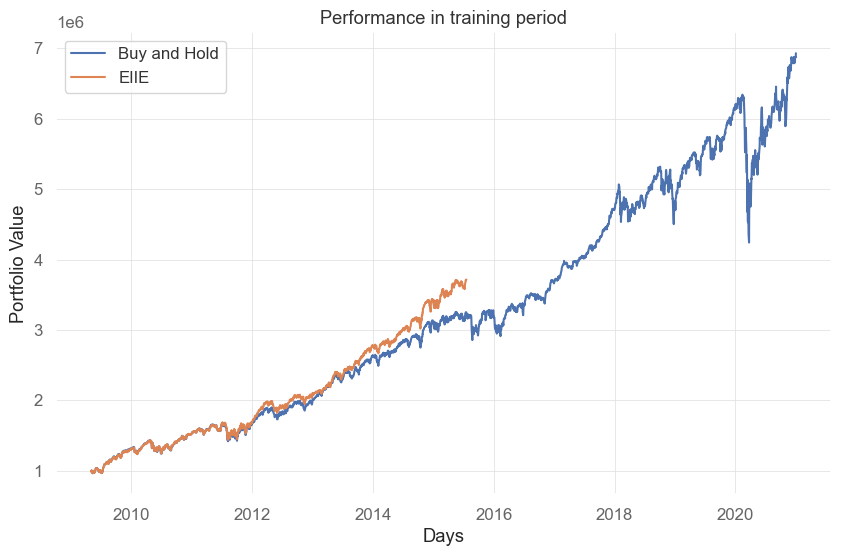

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["date"], UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["date"], EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

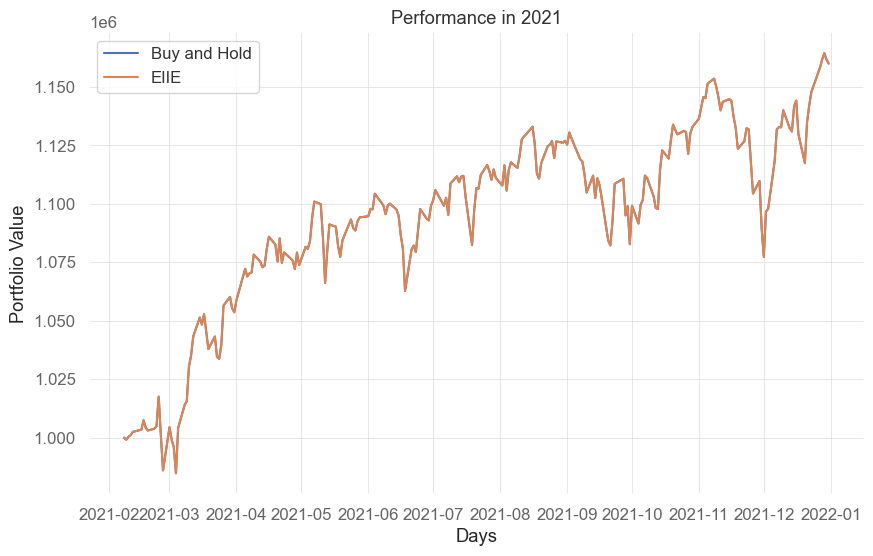

In [99]:
plt.plot(UBAH_results["2021"]["date"], UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["date"], EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

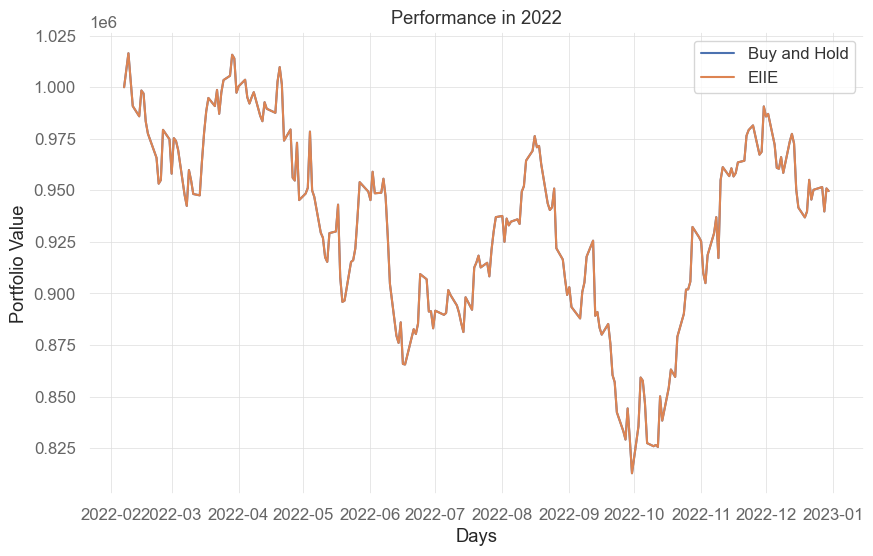

In [100]:
plt.plot(UBAH_results["2022"]["date"], UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["date"], EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

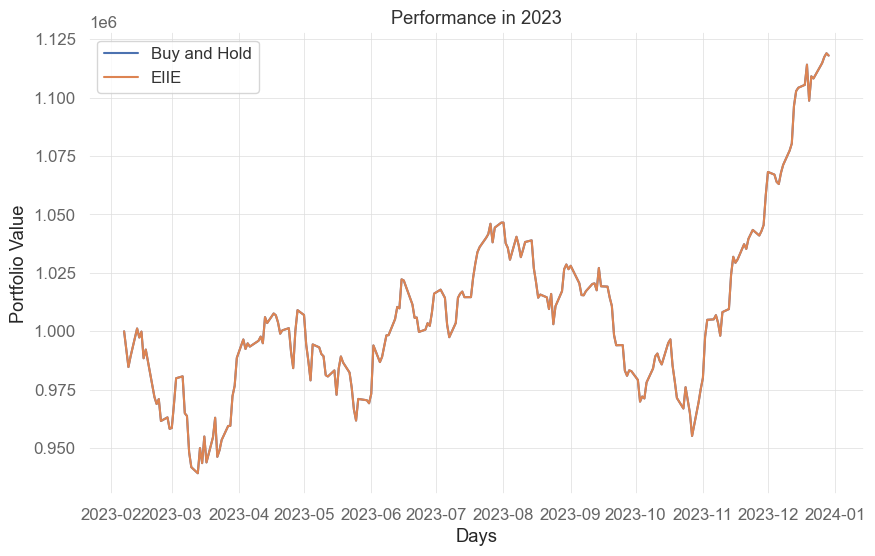

In [101]:
plt.plot(UBAH_results["2023"]["date"], UBAH_results["2023"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2023"]["date"], EIIE_results["2023"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2023")
plt.legend()

plt.show()

# TODO can I used ANOVA, or Analysis of Variance,

Compare with ANova,
Returns 
Drawdown period
And sharpe ratio